In [3]:
import numpy as np
import random
import os 

from PIL import Image
from skimage import io

import torch 
from torch import  optim
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision import datasets

import matplotlib.pyplot as plt
%matplotlib inline

### Download Data

In [4]:
#! wget --directory-prefix=../data/  http://www.mimuw.edu.pl/~ciebie/cityscapes.tgz 
#! tar -xzf ../data/cityscapes.tgz -C ../data/
#! python ../data/cityscapes/check_close.py # Check files
#! rm ../data/cityscapes.tgz
dataset_folder = "../data/cityscapes"

### Creating training, validation dataset

#### Dataset class

In [5]:
class CityScapes(torch.utils.data.Dataset):
    def __init__(self, path, transform = None):
        self.data_folder = path
        self.len = len(os.listdir(path))
        self.transform = transform
        
    def __getitem__(self, idx):
        path_to_file = os.path.join(self.data_folder,os.listdir(self.data_folder)[idx-1])
        image = io.imread(path_to_file)
        
        if self.transform:
            image = self.transform(image)
        return image
    
    def __len__(self):
        return self.len

#### Custom Transformations

In [6]:
class Split(object):
    def __call__(self, concat_X_y):
        return (concat_X_y[:,:256,:],concat_X_y[:,256:,:]) 

class MakeHorizontalFlip(object):
    def __init__(self,p = 0.5):
        self.p = p
        
    def __call__(self,sample):
        
        if random.random() > self.p:
            sample[0][:] = sample[0][:,::-1,:]
            sample[1][:] = sample[1][:,::-1,:]
        
        return transforms.functional.to_tensor(sample[0]), transforms.functional.to_tensor(sample[1])


In [7]:
trsf = transforms.Compose([Split(),MakeHorizontalFlip()])
dataset = CityScapes(dataset_folder, transform=trsf)

torch.Size([3, 256, 256])

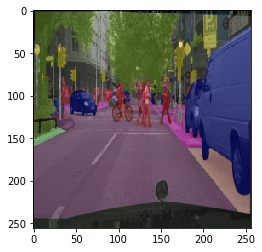

In [32]:
image, image2 = dataset[110]

plt.imshow(image.permute(1,2,0))
plt.imshow(image2.permute(1,2,0),alpha =0.5);

### Create y

In [33]:
im_np =  image.numpy()
check_array = np.array([[116, 17, 36],[152, 43,150],
     [106,141, 34],[ 69, 69, 69],[  2,  1,  3],[127, 63,126],
     [222, 52,211],[  2,  1,140],[ 93,117,119],[180,228,182],
     [213,202, 43],[ 79,  2, 80],[188,151,155],[  9,  5, 91],
     [106, 75, 13],[215, 20, 53],[110,134, 62],[  8, 68, 98],
     [244,171,170],[171, 43, 74],[104, 96,155],[ 72,130,177],
     [242, 35,231],[147,149,149],[ 35, 25, 34],[155,247,151],
     [ 85, 68, 99],[ 71, 81, 43],[195, 64,182],[146,133, 92]])

In [34]:
ar_to_idx = {tuple(i):idx for idx,i in enumerate(check_array)}
im_class = np.empty((256,256), dtype = "int32")
for x in range(im_np.shape[0]):
    for y in range(im_np.shape[0]):
        im_class[x][y] = int(ar_to_idx[tuple(im_np[x][y]*255)])


KeyError: (15.0, 15.0, 17.0, 18.0, 18.0, 18.0, 18.0, 18.0, 15.0, 15.0, 14.0, 14.0, 14.0, 15.0, 16.0, 16.0, 22.0, 20.0, 18.0, 16.0, 16.0, 18.0, 20.0, 22.0, 20.0, 31.0, 37.0, 33.0, 26.0, 26.0, 30.0, 33.0, 44.0, 48.0, 42.0, 34.0, 43.0, 62.0, 64.0, 51.0, 63.0, 65.0, 44.0, 41.0, 34.0, 51.0, 41.0, 39.0, 30.0, 34.0, 31.0, 34.0, 48.0, 55.0, 51.0, 54.0, 47.0, 64.0, 56.0, 47.0, 63.0, 71.0, 70.0, 81.0, 38.0, 79.0, 96.0, 76.0, 97.0, 63.0, 186.0, 181.0, 217.0, 190.0, 138.0, 113.0, 160.0, 112.0, 210.0, 197.0, 206.0, 242.0, 251.0, 239.0, 248.0, 230.0, 238.0, 215.0, 140.0, 16.0, 48.0, 84.0, 211.0, 186.0, 43.0, 0.0, 147.0, 169.0, 60.0, 105.0, 86.0, 112.0, 161.0, 232.0, 119.0, 54.0, 82.0, 59.0, 82.0, 73.0, 96.0, 134.0, 60.0, 72.0, 34.0, 9.0, 41.0, 46.0, 22.0, 22.0, 48.0, 23.0, 27.0, 42.0, 60.0, 89.0, 120.0, 44.0, 7.0, 53.0, 54.0, 65.0, 27.0, 42.0, 144.0, 24.0, 47.0, 0.0, 41.0, 46.0, 143.0, 174.0, 141.0, 70.0, 91.0, 20.0, 195.0, 50.0, 0.0, 105.0, 90.0, 37.0, 36.0, 29.0, 35.0, 11.0, 80.0, 36.0, 39.0, 3.0, 14.0, 17.0, 45.0, 81.0, 79.0, 40.0, 9.0, 3.0, 80.0, 80.0, 90.0, 65.0, 36.0, 46.0, 44.0, 23.0, 12.0, 4.0, 102.0, 32.0, 20.0, 0.0, 16.0, 50.0, 53.0, 48.0, 73.0, 84.0, 87.0, 119.0, 68.0, 30.0, 61.0, 44.0, 67.0, 52.0, 23.0, 0.0, 0.0, 69.0, 48.0, 20.0, 38.0, 104.0, 80.0, 11.0, 13.0, 9.0, 101.0, 145.0, 53.0, 8.0, 22.0, 10.0, 31.0, 22.0, 41.0, 32.0, 34.0, 41.0, 38.0, 27.0, 22.0, 30.0, 25.0, 40.0, 55.0, 69.0, 0.0, 19.0, 77.0, 139.0, 150.0, 206.0, 202.0, 34.0, 8.0, 16.0, 56.0, 118.0, 35.0, 176.0, 53.0, 48.0, 130.0, 134.0, 52.0, 120.0, 125.0, 134.0, 37.0, 127.0, 137.0, 68.0, 34.0, 0.0)

#### Create dataloader

In [35]:
indices = np.arange(dataset.__len__())
np.random.shuffle(indices)

# Random indices for training and validation Ratio 2976 / 500 
val_indices, train_indices =  indices[:500], indices[500:]

train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size = 8, sampler = train_sampler) 
val_loader = DataLoader(dataset, batch_size = 8, sampler = train_sampler)

### Toy Dataset for sanity check

In [36]:
### Create toy dataset to check  implementation
np.random.seed(42)

toy_size = 2
toy_batch = 1

tr_toy_ind = np.random.choice(train_indices, size = toy_size) 
val_toy_ind = np.random.choice(val_indices, size = toy_size) 


train_toy_sampler = torch.utils.data.SubsetRandomSampler(tr_toy_ind)
val_toy_sampler = torch.utils.data.SubsetRandomSampler(val_toy_ind) 

train_toy_loader = DataLoader(dataset=dataset, batch_size=toy_batch, sampler= train_toy_sampler)
val_toy_loader = DataLoader(dataset=dataset, batch_size= toy_batch, sampler = val_toy_sampler)

### Defining U-net, loss_function, optimizer

In [116]:
def make_block(in_channels, out_channels,batch_norm = False):
    block = nn.Sequential(nn.ReplicationPad2d(1),
                              nn.Conv2d(in_channels, out_channels, 3),
                              nn.ReLU(),
                              nn.BatchNorm2d(out_channels),
                              nn.ReplicationPad2d(1),
                              nn.Conv2d(out_channels, out_channels, 3),
                              nn.ReLU(),
                              nn.BatchNorm2d(out_channels)
                             ) 
    return block

In [171]:
class UNet(nn.Module):
    def __init__(self, basic_chl,num_classes = 30,image_channels = 3):
        super(UNet, self).__init__()
        
        #Calculate channels based on basic channel
        BL1_chl, BL2_chl, BL3_chl, BL4_chl, BL5_chl= [basic_chl * i for i in [1,2,4,8,16]]
        
        #Encoder blocks
        self.ENC_BL1 = make_block(image_channels,BL1_chl)
        self.ENC_BL2 = make_block(BL1_chl,BL2_chl)
        self.ENC_BL3 = make_block(BL2_chl,BL3_chl)
        self.ENC_BL4 = make_block(BL3_chl,BL4_chl)
        self.ENC_BL5 = make_block(BL4_chl,BL5_chl)
        
        #MaxPool for downsampling
        self.MaxPool = nn.MaxPool2d(2,2)
        
        #UpConv for upsampling
        self.UpConv1 = nn.ConvTranspose2d(BL5_chl, BL4_chl, 2, stride = 2)
        self.UpConv2 = nn.ConvTranspose2d(BL4_chl, BL3_chl, 2, stride = 2)
        self.UpConv3 = nn.ConvTranspose2d(BL3_chl, BL2_chl, 2, stride = 2)
        self.UpConv4 = nn.ConvTranspose2d(BL2_chl, BL1_chl, 2, stride = 2)
        
        #Decoder blocks
        self.DEC_BL1 = make_block(BL5_chl,BL4_chl)
        self.DEC_BL2 = make_block(BL4_chl,BL3_chl)
        self.DEC_BL3 = make_block(BL3_chl,BL2_chl)
        self.DEC_BL4 = make_block(BL2_chl,BL1_chl)
        
        # Last convolution
        self.Final_CONV = nn.Conv2d(basic_chl, num_classes, 1)
        
    
    def forward(self,X):
        # Encoder
        ENC_1_out = self.ENC_BL1.forward(X)
        MaxENC_1_out = self.MaxPool.forward(ENC_1_out)
        
        ENC_2_out = self.ENC_BL2.forward(MaxENC_1_out)
        MaxENC_2_out = self.MaxPool.forward(ENC_2_out)
        
        ENC_3_out = self.ENC_BL3.forward(MaxENC_2_out)
        MaxENC_3_out = self.MaxPool.forward(ENC_3_out)
        
        ENC_4_out = self.ENC_BL4.forward(MaxENC_3_out)
        MaxENC_4_out = self.MaxPool.forward(ENC_4_out)
                
        # Bridge to Decoder
        ENC_5_out = self.ENC_BL5.forward(MaxENC_4_out)
        UpENC_5_out = self.UpConv1.forward(ENC_5_out)  
        
        #Decoder
        DEC_1_in = torch.cat((UpENC_5_out,ENC_4_out), dim = 1)
        DEC_1_out = self.DEC_BL1.forward( DEC_1_in)
        UpDEC_1_out = self.UpConv2.forward(DEC_1_out)
        
        
        DEC_2_in = torch.cat((UpDEC_1_out,ENC_3_out), dim = 1)
        DEC_2_out = self.DEC_BL2.forward(DEC_2_in)
        UpDEC_2_out = self.UpConv3.forward(DEC_2_out)
        
        DEC_3_in = torch.cat((UpDEC_2_out,ENC_2_out), dim = 1)
        DEC_3_out = self.DEC_BL3.forward(DEC_3_in)
        UpDEC_3_out = self.UpConv4.forward(DEC_3_out)
        
        DEC_4_in = torch.cat((UpDEC_3_out,ENC_1_out), dim = 1)
        DEC_4_out = self.DEC_BL4.forward(DEC_4_in)
          
        #Final Convolution    
        segmenatation_map = self.Final_CONV.forward(DEC_4_out)
    
        return segmenatation_map
    

In [172]:
X_b = torch.Tensor(np.array(np.arange(2* 3 * 256 * 256)).reshape(2,3,256,256))
model = UNet(4)
model.forward(X_b).shape

torch.Size([2, 30, 256, 256])

In [ ]:
model = Unet(4)


device = torch.cuda.device("cuda:0" if torch.cuda.is_available()  else "cpu")

model.to(device)
model.type(torch.cuda.FloatTensor)

if torch.cuda.device_count() > 1:
    print("GPU: ", torch.cuda.device_count())
    model = nn.DataParallel(model)


loss = nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr =1e-3, weight_decay=1e-4)

### Training model

In [ ]:
def compute_validation_accuracy(model, val_loader):
    accuracy = 0
    model.eval()
    for x,y in val_loader:
        model(x)

In [ ]:
def train_model(model, optimizer, loss_function, num_epochs):
    

### Random Hyper-parameter search
    Parameters:
    - learning rate
    - weight decay
    
    Algorithm:
    1) Get random sample from search space
    2) Define model with given parameters and train 1 epoch. Check whether training starts well
    3) 
    5) Final search performs N times and return best parameters

In [ ]:
def Random search(dict_of_params, N):
    best_score = 0.0
    dict_evaluations
    
    
    for i in range(N):
        
        # Get random parameters
        sample = {par_name:10 ** np.random.uniform(r[0],r[1]) for par_name, r in param_dict.items() }
    
        # Define model
        model = UNet(4)
        optimizer = torch.optim.Adam(model.params(), lr =sample["lr"], weight_decay=sample["L2"])
        # loss function
        
        #perform training
        train_loss_h, train_acc, val_acc_history, = def train_model(model, optimizer, loss_function, 1)
        
        if  (train_loss_h[0] > loss_threshold) :
            dict_evaluations[ ] = train_loss_h
            continue
            # Training exploded and there is no sense to continue
    
        
        if val_acc_history[-1] > best_score:
            best_score = val_acc_history[-1]
            best_params = params
            
        dict_evaluations[tuple([(name,val) for name,val in sample])] = val_acc_history
        
    return dict_evaluations

In [359]:
dict_params = {
    "lr" : [-5,-1],
    "lr_annealing" : [],
    "L2" : [-6,-1],
    "Dropout" : [-1,0],
}

1.2575549573395253e-05

In [345]:
np.random.rand()

0.22210781047073025